In [2]:
import fidimag
import sys
import matplotlib.pyplot as plt
import holoviews as hv
import finitedifferencefield
hv.notebook_extension()
%matplotlib inline
sys.path.append('/home/ryan/Git/joommf/tools/')
import os
os.environ['OMP_NUM_THREADS'] = '4'

In [17]:
%opts Image style(interpolation='nearest', cmap='RdBu')[colorbar=True]
%output size=600

In [3]:
def fidimag_to_finitedifferencefield(sim):
    """
    fidimag_to_finitedifferencefield(sim)

    This function takes a Fidimag simulation object, and constructs a
    Finite Difference Field object which has the magnetisation configuration
    from the simulation at the last time step.
    """
    cmin = np.array([sim.mesh.x0, sim.mesh.y0, sim.mesh.z0])*sim.mesh.unit_length
    cmax = tuple(cmin +np.array([mesh.Lx, mesh.Ly, mesh.Lz])*sim.mesh.unit_length)
    cmin = tuple(cmin)
    d = tuple(np.array([sim.mesh.dx, sim.mesh.dy, sim.mesh.dz])*sim.mesh.unit_length)
    field = finitedifferencefield.Field(cmin, cmax, d)
    numpyfield = sim.spin.copy().reshape((mesh.nx, mesh.ny, mesh.nz, 3))
    field.f = numpyfield
    return field

def field2outofplane(field, slice_axis, slice_coord):
    """
    field2hv(field, slice_axis, slice_coord)
    This function constructs a Holoviews object
    which shows the out of plane Magnetisation
    Inputs
    ======
    field:
        Path to an OMF file or object of type oommffield.Field
    slice_axis:
        The axis along which the vector field will be sliced given as a string.
        Must be one of ['x', 'y', 'z']
    slice_coord:
        The coordinate along the slice_axis where the field is sliced
    """
    # Construct a field object if not a field object
    if isinstance(field, str):
        field = oommffield.read_oommf_file(field)
    field.normalise()
    if slice_axis == 'z':
        axis = (0, 1, 2)
    elif slice_axis == 'y':
        axis = (0, 2, 1)
    elif slice_axis == 'x':
        axis = (1, 2, 0)
    else:
        raise ValueError("Slice Axis must be one of 'x', 'y' ,'z'")
    dims = ['x', 'y', 'z']
    bounds = [field.cmin[axis[0]],
              field.cmin[axis[1]],
              field.cmax[axis[0]],
              field.cmax[axis[1]]]
    x, y, vec, coords = field.slice_field(slice_axis, slice_coord)
    X, Y = np.meshgrid(x, y)
    flat = vec.flatten()
    modm = (flat[axis[0]::3]**2 +
            flat[axis[1]::3]**2).reshape((len(x), len(y)))
    angm = np.arctan2(flat[axis[1]::3],
                      flat[axis[0]::3]).reshape((len(x), len(y)))
    outofplane = flat[axis[2]::3]
    mz = flat[axis[2]::3].reshape((len(x), len(y)))
    kdims = kdims = [dims[axis[0]], dims[axis[1]]]
    return hv.Image(mz, bounds=bounds,
                    label='Out of plane Magnetisation',
                    kdims=kdims,
                    vdims=[hv.Dimension('M{}'.format(slice_axis),
                                        range=(-1, 1))])

In [4]:
import matplotlib.pyplot as plt


:Image   [x,y]   (Mz)
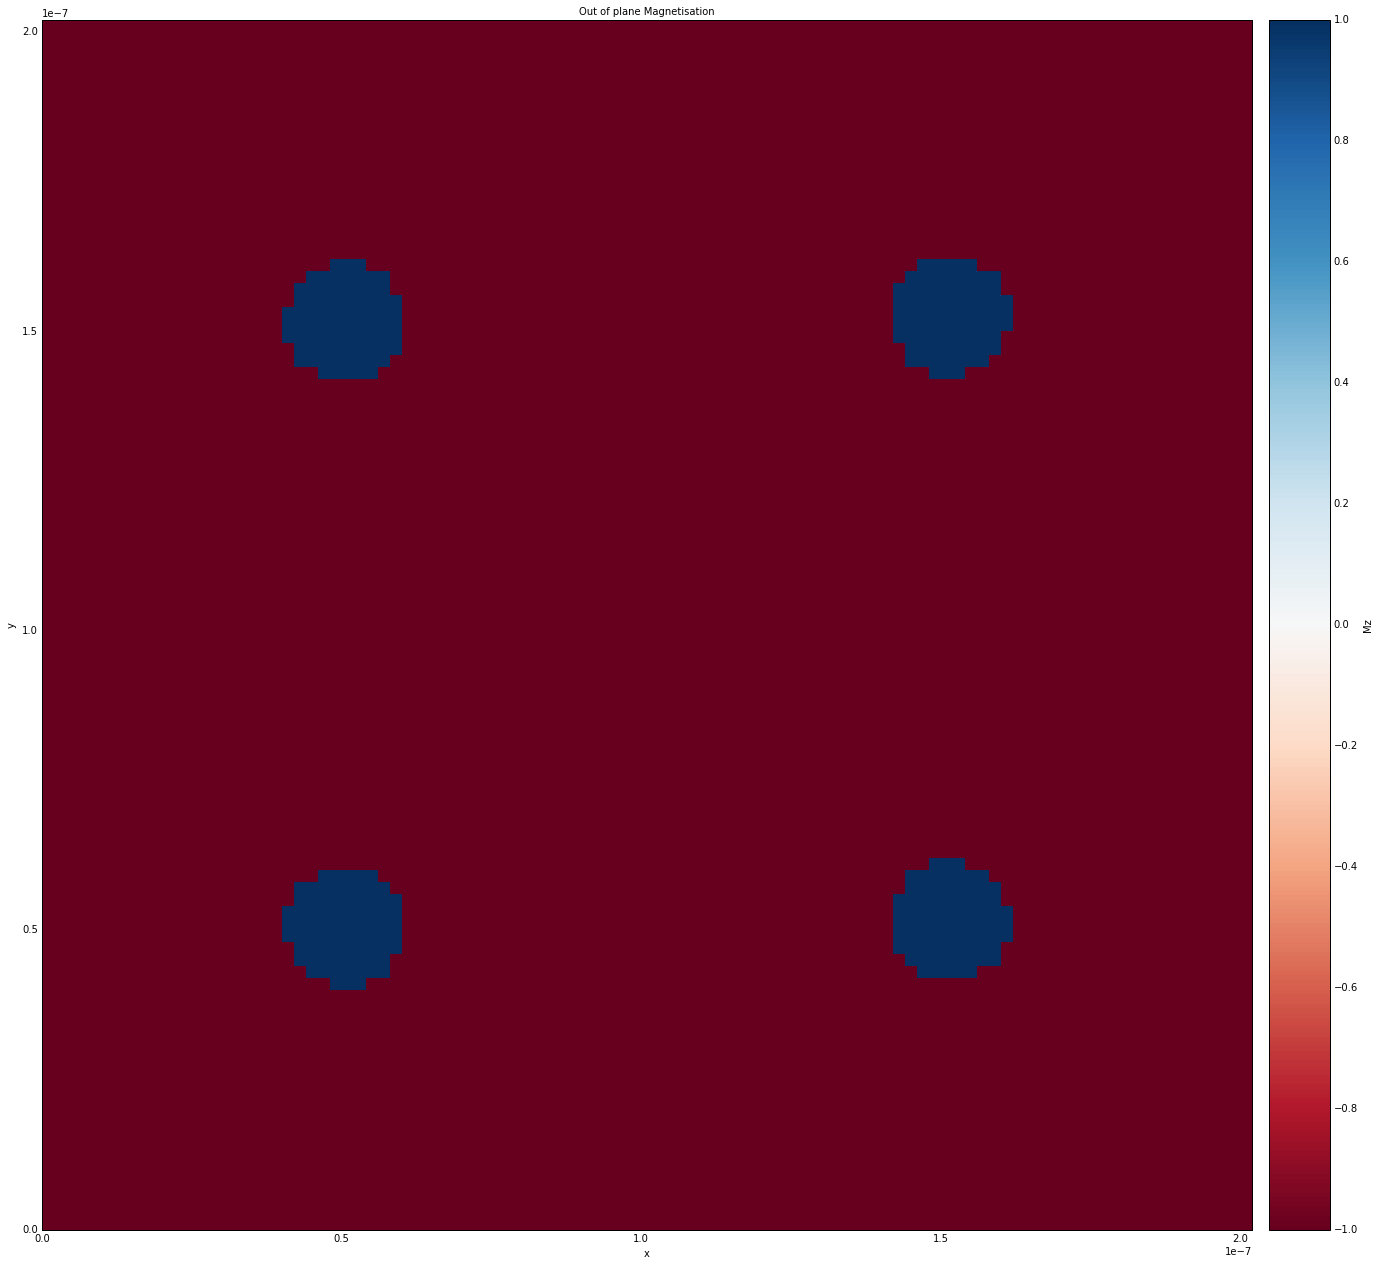

In [72]:
import numpy as np
from fidimag.micro import Sim
from fidimag.common import CuboidMesh
from fidimag.micro import UniformExchange, DMI, Zeeman, Demag
data = []
mu0 = 4 * np.pi * 1e-7


def init_m(pos):
    x, y = pos[0] - 100, pos[1] - 100
    if x**2 + y**2 < 20**2:
        return (0, 0, 1)
    else:
        return (0, 0, -1)

mesh = CuboidMesh(nx=101, ny=101, nz=2, dx=2.0, dy=2.0, dz=2.0, unit_length=1e-9, periodicity=(True, True, False))

sim = Sim(mesh, name='relax', integrator='sundials_openmp')

sim.driver.set_tols(rtol=1e-6, atol=1e-6)
sim.alpha = 0.5
sim.gamma = 2.211e5
sim.Ms = 8.6e5
sim.do_precession = True

sim.set_m(init_m)

exch = UniformExchange(A=1.3e-11)
sim.add(exch)
sim.add(Demag())
dmi = DMI(D=-4e-3)
sim.add(dmi)

zeeman = Zeeman((0, 0, 4e5))
sim.add(zeeman, save_field=True)
start_m = fidimag_to_finitedifferencefield(sim)
data.append(start_m)


steps = 31
field2outofplane(start_m, 'z', 0)




In [78]:
for t in np.linspace(1e-9, 2e-9, steps):
    print(t)
    sim.driver.run_until(t)
    data.append(fidimag_to_finitedifferencefield(sim))


1e-09
1.03333333333e-09
1.06666666667e-09
1.1e-09
1.13333333333e-09
1.16666666667e-09
1.2e-09
1.23333333333e-09
1.26666666667e-09
1.3e-09
1.33333333333e-09
1.36666666667e-09
1.4e-09
1.43333333333e-09
1.46666666667e-09
1.5e-09
1.53333333333e-09
1.56666666667e-09
1.6e-09
1.63333333333e-09
1.66666666667e-09
1.7e-09
1.73333333333e-09
1.76666666667e-09
1.8e-09
1.83333333333e-09
1.86666666667e-09
1.9e-09
1.93333333333e-09
1.96666666667e-09
2e-09


In [79]:
func = lambda i: field2outofplane(data[i], 'z', 0)

In [80]:
len(data)

63

:DynamicMap   [time]
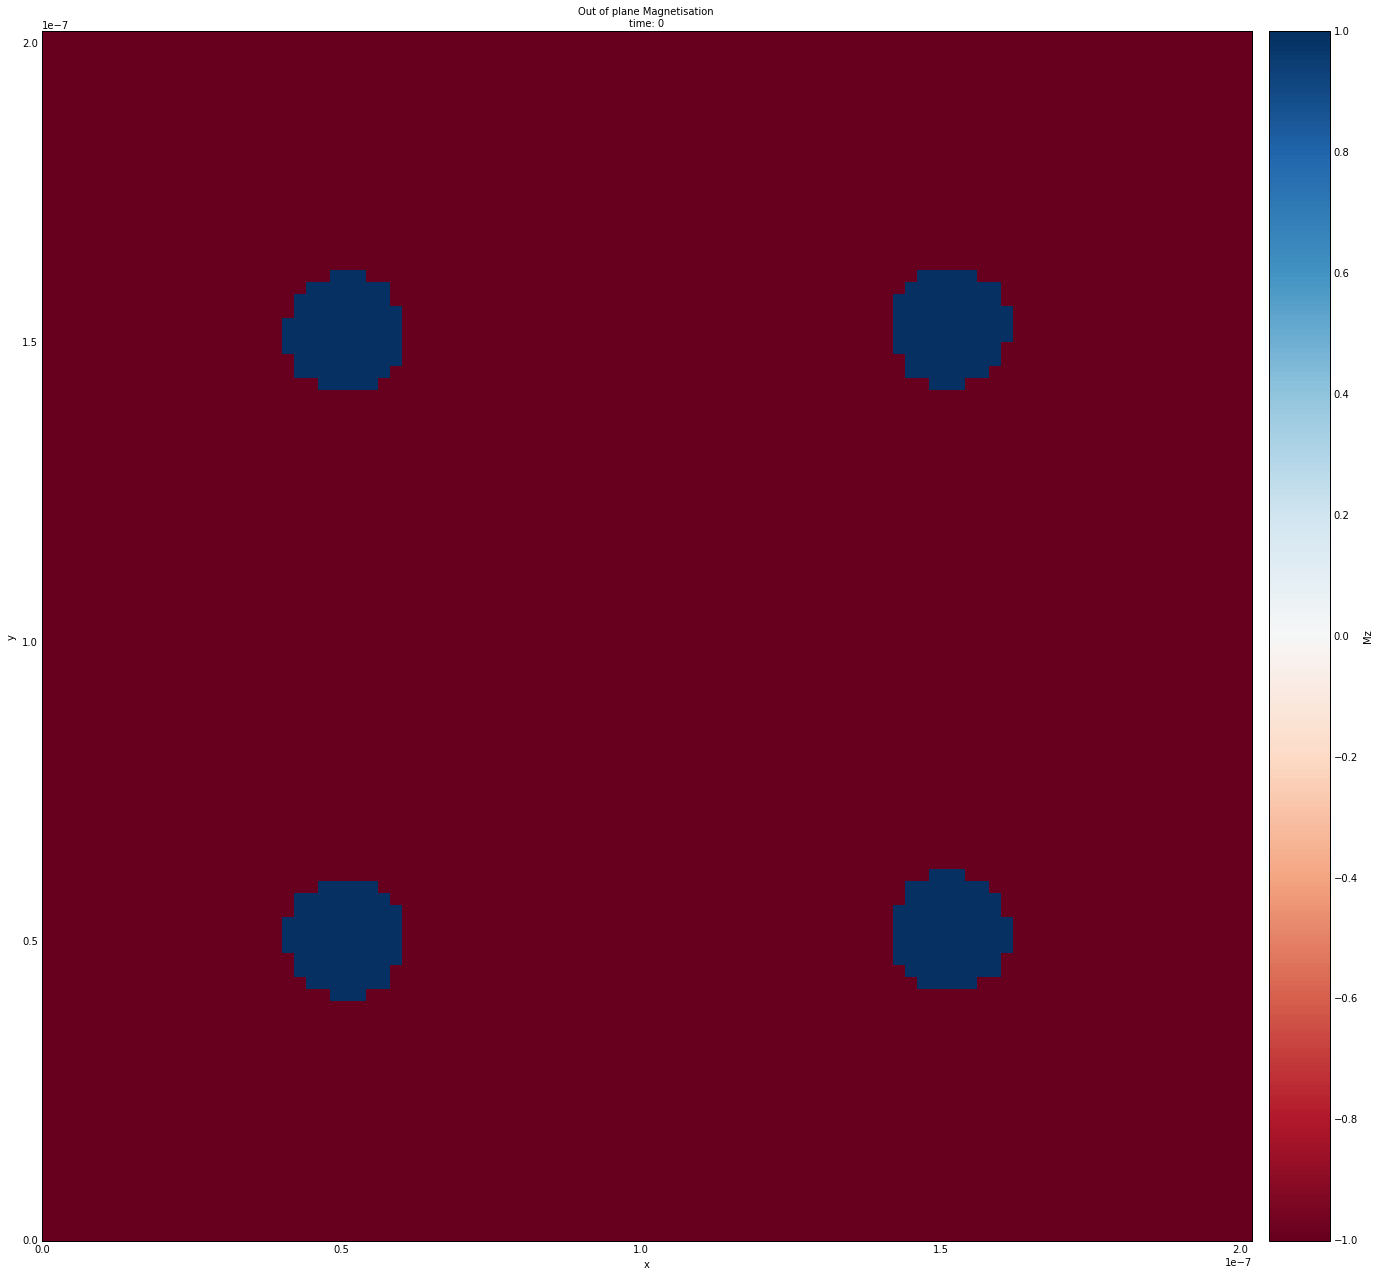

In [81]:
hv.DynamicMap(func, kdims=[hv.Dimension('time', values=range(63))])

In [71]:
%%opts GridSpace [xaxis=None yaxis=None] Path [bgcolor='w' xaxis=None yaxis=None]
map.groupby(['time'], group_type=hv.NdOverlay, container_type=hv.GridSpace)

AssertionError: GridSpace must only contain one type of object, not both NoneType and Image.

In [ ]:
%output size=400

In [ ]:
sim.relax(dt=1e-1)

In [ ]:
field = fidimag_to_finitedifferencefield(sim)

In [ ]:
%%opts Image style(interpolation='nearest', cmap='RdBu')[colorbar=True, image_size=800]
field2outofplane(field, 'z', 0)

In [ ]:
spin_copy = sim.spin
spin_copy.reshape(-1, 3)

In [ ]:
2 + 2